In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math


In [3]:
def get_image(image_path):
    return cv2.imread(image_path)

In [4]:
image = get_image('./Dataset/game1/Clip1/0000.jpg')

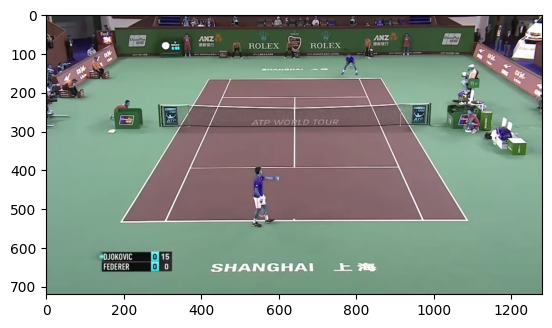

In [5]:
plt.imshow(image)

In [ ]:
# Mouse callback function to collect points
points=[]
cv2.imshow('Select Points', image)
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print("Point selected: ({}, {})".format(x, y))

# Set the mouse callback
cv2.setMouseCallback('Select Points', get_points)

# Wait for the user to select points
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", points)

In [6]:
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
points=[(420, 165), (860, 165), (1090, 530), (200, 530), (291, 230), (992, 230)]
#plot points on frame
for point in points:
    cv2.circle(image, point, 5, (0, 0, 255), -1)
cv2.imshow('points',image)
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()



In [7]:
#true coords
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
true_coords = [(0,23.77, 0), (10.97,23.77,  0), (10.97,0, 0),(0,0,0), (-0.91, 5.485,1.07), (11.42,5.485,1.07)]

In [8]:
A = []
for i in range(6):
    X, Y, Z = true_coords[i]
    u, v = points[i]
    A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
    A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

In [9]:
A = np.array(A)


In [10]:
image.shape

(720, 1280, 3)

In [11]:
# svd of A
U, S, V = np.linalg.svd(A)

In [12]:
V.shape

(12, 12)

In [13]:
# get last column of V
p = V[-1, :]

In [14]:
p.shape

(12,)

In [15]:
# reshape to 
M3D = np.reshape(p, (3, 4))

In [16]:
M3D

array([[-1.33991539e-01, -4.51309383e-02, -2.14865150e-01,
        -3.30311726e-01],
       [-7.58370101e-19,  1.36356071e-02,  2.41561812e-01,
        -8.75326075e-01],
       [-3.41790523e-17, -7.10599098e-05, -2.94837532e-04,
        -1.65155863e-03]])

In [17]:
a1 = M3D[0, :3]
a2 = M3D[1, :3]
a3 = M3D[2, :3]
b1 = M3D[0, 3]
b2 = M3D[1, 3]
b3 = M3D[2, 3]

In [18]:
rho = 1 / np.linalg.norm(a3)
cx = rho**2 * np.dot(a1, a3)
cy = rho**2 * np.dot(a2, a3)
cos_theta = -np.dot(np.cross(a1, a3), np.cross(a2, a3)) / (np.linalg.norm(np.cross(a1, a3)) * np.linalg.norm(np.cross(a2, a3)))
sin_tetha = np.sqrt(1 - cos_theta**2)
alpha = rho**2 * np.linalg.norm(np.cross(a1, a3)) * sin_tetha
beta = rho**2 * np.linalg.norm(np.cross(a2, a3)) * sin_tetha

In [19]:
cy

-784.8604998864747

In [20]:
K = np.array([[alpha, -alpha* (cos_theta/sin_tetha), cx], [0, beta/ sin_tetha, cy], [0, 0, 1]])
#K = np.array([[alpha, 0, cx], [0, alpha, cy], [0, 0, 1]])

In [21]:
K

array([[ 441.80821527,  -21.33107103,  723.6167164 ],
       [   0.        ,  142.91433308, -784.86049989],
       [   0.        ,    0.        ,    1.        ]])

In [22]:
# get R and T
r1 = (np.cross(a2, a3) / np.linalg.norm(np.cross(a2, a3)))
r3= rho * a3
r2 = np.cross(r3, r1)

In [23]:
b = np.array([b1, b2, b3])
t = rho* np.linalg.inv(K).dot(b)

In [24]:
# use K R and t to project the points in 3d and show with matplotlib
points_2d = np.array(points)
# add 1 to the points
points_2d = np.hstack((points_2d, np.ones((6, 1))))
points_2d


array([[4.20e+02, 1.65e+02, 1.00e+00],
       [8.60e+02, 1.65e+02, 1.00e+00],
       [1.09e+03, 5.30e+02, 1.00e+00],
       [2.00e+02, 5.30e+02, 1.00e+00],
       [2.91e+02, 2.30e+02, 1.00e+00],
       [9.92e+02, 2.30e+02, 1.00e+00]])

In [25]:
R = np.array([r1, r2, r3])

In [26]:
t = t.reshape(3, 1)
t

array([[  4.03503228],
       [-50.10191201],
       [ -5.44565856]])

In [27]:
points_normalized = np.linalg.inv(K) @ points_2d.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T


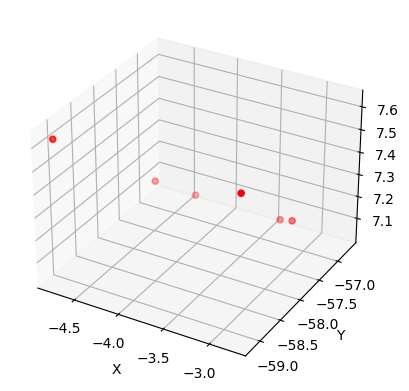

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [29]:
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

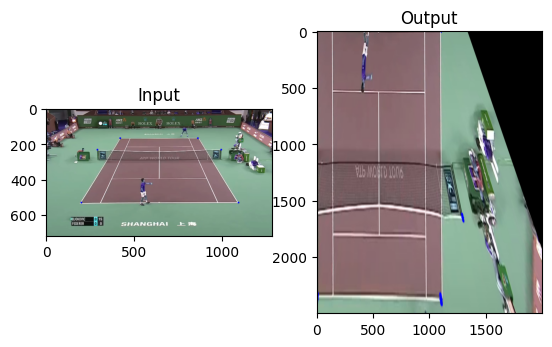

In [63]:
rows,cols,ch = image.shape

pts1 = np.float32([[420, 165], [860, 165], [1090, 530], [200, 530]])

ratio=0.02
cardH=math.sqrt((pts1[2][0]-pts1[1][0])*(pts1[2][0]-pts1[1][0])+(pts1[2][1]-pts1[1][1])*(pts1[2][1]-pts1[1][1]))
cardW=ratio*cardH
pts2 = np.float32([[0,2377], [1097,2377], [1097,0],[0,0]])

M = cv2.getPerspectiveTransform(pts1,pts2)

offsetSize=20
transformed = np.zeros((int(cardW+offsetSize), int(cardH+offsetSize)), dtype=np.uint8);
dst = cv2.warpPerspective(image, M, (2000,2500))

plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [64]:
rectified_pts = cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), M)

# Print the coordinates of original points in the new rectified image
for point in rectified_pts:
    x, y = point[0]
    print("Original Point: ({}, {}) -> New Rectified Image: ({}, {})".format(pts1[0][0], pts1[0][1], x, y))

Original Point: (420.0, 165.0) -> New Rectified Image: (2.4450455765948065e-13, 2377.0)
Original Point: (420.0, 165.0) -> New Rectified Image: (1097.0, 2377.0)
Original Point: (420.0, 165.0) -> New Rectified Image: (1097.0, 0.0)
Original Point: (420.0, 165.0) -> New Rectified Image: (1.2087866243983697e-13, -2.4175732487967394e-13)


In [65]:
point1= np.float32([420, 165, 1])
corenr=np.dot(M , point1)
corner= corenr/corenr[2]
corner

array([2.44504569e-13, 2.37700000e+03, 1.00000000e+00])

In [66]:
rectified_pts

array([[[ 2.4450456e-13,  2.3770000e+03]],

       [[ 1.0970000e+03,  2.3770000e+03]],

       [[ 1.0970000e+03,  0.0000000e+00]],

       [[ 1.2087866e-13, -2.4175732e-13]]], dtype=float32)

In [78]:
d_3pts = []
for point in rectified_pts:
    x, y = point[0]
    point_3d = np.array([x, y, 1])
    #point_3d = np.dot(np.linalg.inv(M), point_3d)
    d_3pts.append(point_3d)
d_3pts
    

[array([2.44504558e-13, 2.37700000e+03, 1.00000000e+00]),
 array([1.097e+03, 2.377e+03, 1.000e+00]),
 array([1.097e+03, 0.000e+00, 1.000e+00]),
 array([ 1.20878662e-13, -2.41757325e-13,  1.00000000e+00])]

In [79]:
d_3pts = np.array(d_3pts)

In [80]:
x = d_3pts[:, 0]
y = d_3pts[:, 1]
z = d_3pts[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])
#connect the 4 points
fig.add_trace(go.Scatter3d(x=[x[0], x[1]], y=[y[0], y[1]], z=[z[0], z[1]], mode='lines', name='top'))
fig.add_trace(go.Scatter3d(x=[x[1], x[2]], y=[y[1], y[2]], z=[z[1], z[2]], mode='lines', name='right'))
fig.add_trace(go.Scatter3d(x=[x[2], x[3]], y=[y[2], y[3]], z=[z[2], z[3]], mode='lines', name='bottom'))
fig.add_trace(go.Scatter3d(x=[x[3], x[0]], y=[y[3], y[0]], z=[z[3], z[0]], mode='lines', name='left'))

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [81]:
d_3pts= np.array(d_3pts)

In [82]:
points_normalized = np.linalg.inv(K) @ d_3pts.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T

In [83]:
points_3d

array([[ -4.60470152, -71.72578407,  10.65668005],
       [ -2.1217237 , -71.72578407,  10.65668005],
       [ -2.92475462, -55.55643366,   6.75964369],
       [ -5.40773244, -55.55643366,   6.75964369]])

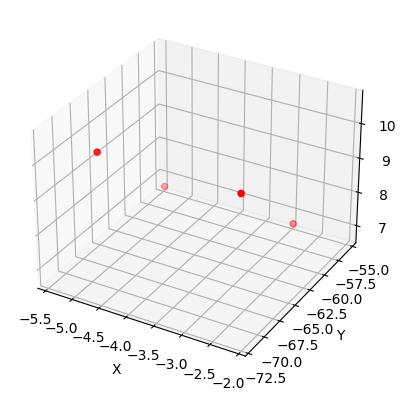

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [85]:
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])
#connect the 4 points
fig.add_trace(go.Scatter3d(x=[x[0], x[1]], y=[y[0], y[1]], z=[z[0], z[1]], mode='lines', name='top'))
fig.add_trace(go.Scatter3d(x=[x[1], x[2]], y=[y[1], y[2]], z=[z[1], z[2]], mode='lines', name='right'))
fig.add_trace(go.Scatter3d(x=[x[2], x[3]], y=[y[2], y[3]], z=[z[2], z[3]], mode='lines', name='bottom'))
fig.add_trace(go.Scatter3d(x=[x[3], x[0]], y=[y[3], y[0]], z=[z[3], z[0]], mode='lines', name='left'))

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [86]:
# calcula the distance between the 2 points
def distance_3d(point1, point2):
    return np.linalg.norm(point1[:2] - point2[:2])
for i in range(4):
    for j in range(i+1, 4):
        print("Distance between point {} and point {} is: {}".format(i, j, distance_3d(points_3d[i], points_3d[j])))

Distance between point 0 and point 1 is: 2.4829778217977547
Distance between point 0 and point 2 is: 16.256386884780447
Distance between point 0 and point 3 is: 16.18927891011029
Distance between point 1 and point 2 is: 16.189278910110296
Distance between point 1 and point 3 is: 16.499871103681418
Distance between point 2 and point 3 is: 2.4829778217977543


In [87]:
ball_coordinates= pd.read_csv('../outcsv/ball_track.csv')    

In [90]:
# get ball coordinates as an matrix of points
ball_points = ball_coordinates[['x', 'y']].values
#convert to float32
ball_points = np.array(ball_points, dtype=np.float32)
rectified_pts_ball = cv2.perspectiveTransform(ball_points.reshape(-1, 1, 2), M)
x = rectified_pts_ball[:, 0, 0]
y = rectified_pts_ball[:, 0, 1]
# bring the rectified points in 3d
d_3pts = []
for point in rectified_pts_ball:
    x, y = point[0]
    point_3d = np.array([x, y, 1])
    #point_3d = np.dot(np.linalg.inv(M), point_3d)
    d_3pts.append(point_3d)
d_3pts
d_3pts = np.array(d_3pts)
points_normalized = np.linalg.inv(K) @ d_3pts.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T
x = d_3pts[:, 0]
y = d_3pts[:, 1]
z = d_3pts[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()
# Print the coordinates of original points in the new rectified image
# for point in rectified_pts_ball:
#     x, y = point[0]
#     #plot with cv2
#     cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)
#     # show image
#     cv2.imshow('points',dst)
#     if cv2.waitKey(100) & 0xFF == ord('q'):
#             break
# cv2.destroyAllWindows()



In [92]:
d_3pts

array([[ 1.24050342e+03,  2.60488477e+03,  1.00000000e+00],
       [ 1.24050342e+03,  2.60488477e+03,  1.00000000e+00],
       [ 1.24050342e+03,  2.60488477e+03,  1.00000000e+00],
       [ 9.59598572e+02,  1.62926721e+03,  1.00000000e+00],
       [ 7.71520325e+02,  9.76047974e+02,  1.00000000e+00],
       [ 6.83821716e+02,  5.91759827e+02,  1.00000000e+00],
       [ 6.14416748e+02,  2.87632843e+02,  1.00000000e+00],
       [ 5.58122070e+02,  4.09538727e+01,  1.00000000e+00],
       [ 4.78647095e+02, -2.17420471e+02,  1.00000000e+00],
       [ 4.78647095e+02, -2.17420471e+02,  1.00000000e+00],
       [ 4.27075134e+02, -2.56367706e+02,  1.00000000e+00],
       [ 3.95478180e+02, -2.75306274e+02,  1.00000000e+00],
       [ 3.64454742e+02, -2.93901062e+02,  1.00000000e+00],
       [ 3.16757385e+02, -3.30096161e+02,  1.00000000e+00],
       [ 3.19155701e+02, -3.22960754e+02,  1.00000000e+00],
       [ 2.17164764e+02, -4.87284271e+02,  1.00000000e+00],
       [ 2.17164764e+02, -4.87284271e+02

In [105]:
# height rectification
# Mouse callback function to collect points
points=[]
cv2.imshow('Select Points', image)
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print("Point selected: ({}, {})".format(x, y))

# Set the mouse callback
cv2.setMouseCallback('Select Points', get_points)

# Wait for the user to select points
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", points)

Point selected: (291, 231)
Point selected: (993, 231)
Point selected: (293, 290)
Point selected: (990, 288)
Point selected: (192, 535)
Point selected: (1090, 532)
Selected Points: [(291, 231), (993, 231), (293, 290), (990, 288), (192, 535), (1090, 532)]


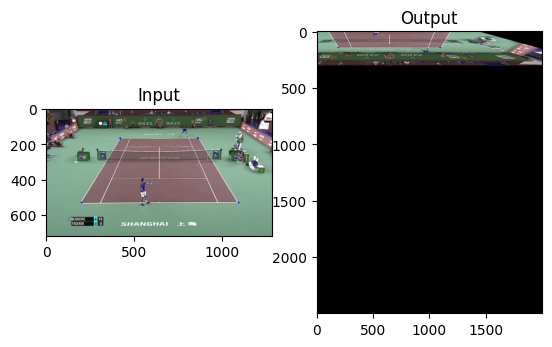

In [112]:
rows,cols,ch = image.shape

pts1 = np.float32([[290, 230], [990, 230],  [190, 530], [1090, 530]])

ratio=0.02
cardH=math.sqrt((pts1[2][0]-pts1[1][0])*(pts1[2][0]-pts1[1][0])+(pts1[2][1]-pts1[1][1])*(pts1[2][1]-pts1[1][1]))
cardW=ratio*cardH
pts2 = np.float32([[0,107], [1279,107],  [91, 0],[1188,0]])

M = cv2.getPerspectiveTransform(pts1,pts2)

offsetSize=20
transformed = np.zeros((int(cardW+offsetSize), int(cardH+offsetSize)), dtype=np.uint8);
dst = cv2.warpPerspective(image, M, (2000,2500))

plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [113]:
rectified_pts_ball = cv2.perspectiveTransform(ball_points.reshape(-1, 1, 2), M)

# Print the coordinates of original points in the new rectified image
for point in rectified_pts_ball:
    x, y = point[0]
    #plot with cv2
    cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)
    # show image
    cv2.imshow('points',dst)
    if cv2.waitKey(100) & 0xFF == ord('q'):
            break
cv2.destroyAllWindows()

In [95]:
def plot_heigth(dst, ball_points, M):
        rectified_pts_ball = cv2.perspectiveTransform(ball_points.reshape(-1, 1, 2), M)

        # Print the coordinates of original points in the new rectified image
        for point in rectified_pts_ball:
            x, y = point[0]
            #plot with cv2
            cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)
            # show image
            cv2.imshow('points',dst)
            if cv2.waitKey(100) & 0xFF == ord('q'):
                    break
        cv2.destroyAllWindows()

In [96]:
plot_heigth(dst, ball_points, M)

In [97]:
rectified_pts_ball

array([[[1119.8073  ,  252.99153 ]],

       [[1119.8073  ,  252.99153 ]],

       [[1119.8073  ,  252.99153 ]],

       [[ 997.0014  ,  100.65254 ]],

       [[ 874.1956  ,  -51.68644 ]],

       [[ 803.2411  , -173.19492 ]],

       [[ 732.2866  , -294.7034  ]],

       [[ 661.33215 , -416.21185 ]],

       [[ 535.7973  , -573.9915  ]],

       [[ 535.7973  , -573.9915  ]],

       [[ 448.46872 , -601.1949  ]],

       [[ 393.88834 , -614.79663 ]],

       [[ 339.30795 , -628.3983  ]],

       [[ 251.97937 , -655.6017  ]],

       [[ 257.4374  , -650.161   ]],

       [[  33.657894, -786.178   ]],

       [[  33.657894, -786.178   ]],

       [[  58.219063, -723.61017 ]],

       [[  82.78023 , -661.04236 ]],

       [[ 153.73471 , -546.78815 ]],

       [[ 148.27667 , -557.6695  ]],

       [[ 344.766   , -280.19492 ]],

       [[ 344.766   , -280.19492 ]],

       [[ 382.97226 , -220.34746 ]],

       [[ 421.17853 , -160.5     ]],

       [[ 492.133   ,  -62.567795]],

       [[ 49

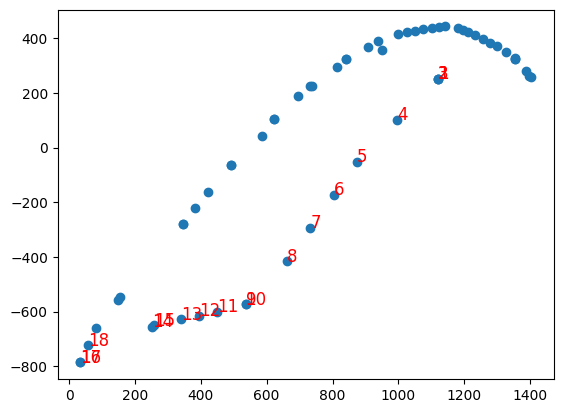

In [98]:
#plot a chart of the points
x = rectified_pts_ball[:, 0, 0]
y = rectified_pts_ball[:, 0, 1]
# along with each poitn plot a number from 1 to size of points array
for i in range(18):
    plt.text(x[i], y[i], str(i+1), color='red', fontsize=12)


plt.scatter(x, y)

In [99]:
# bring the rectified points in 3d
d_3pts = []
for point in rectified_pts_ball:
    x, y = point[0]
    point_3d = np.array([x, y, 1])
    #point_3d = np.dot(np.linalg.inv(M), point_3d)
    d_3pts.append(point_3d)
d_3pts

[array([1.11980725e+03, 2.52991531e+02, 1.00000000e+00]),
 array([1.11980725e+03, 2.52991531e+02, 1.00000000e+00]),
 array([1.11980725e+03, 2.52991531e+02, 1.00000000e+00]),
 array([997.00140381, 100.65254211,   1.        ]),
 array([874.19561768, -51.68643951,   1.        ]),
 array([ 803.24108887, -173.19491577,    1.        ]),
 array([ 732.28662109, -294.70339966,    1.        ]),
 array([ 661.33215332, -416.21185303,    1.        ]),
 array([ 535.79730225, -573.99151611,    1.        ]),
 array([ 535.79730225, -573.99151611,    1.        ]),
 array([ 448.46871948, -601.19488525,    1.        ]),
 array([ 393.88833618, -614.79663086,    1.        ]),
 array([ 339.30795288, -628.39831543,    1.        ]),
 array([ 251.97937012, -655.60168457,    1.        ]),
 array([ 257.43740845, -650.16101074,    1.        ]),
 array([  33.65789413, -786.17797852,    1.        ]),
 array([  33.65789413, -786.17797852,    1.        ]),
 array([  58.21906281, -723.61016846,    1.        ]),
 array(

In [100]:
d_3pts = np.array(d_3pts)

In [101]:
points_normalized = np.linalg.inv(K) @ d_3pts.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T

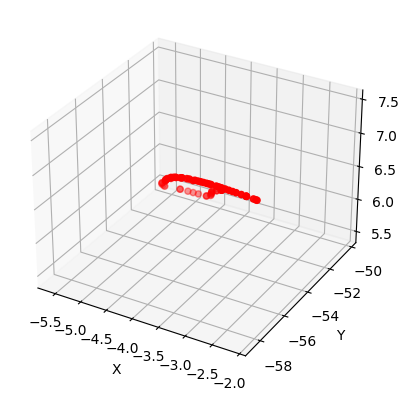

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [103]:
x = d_3pts[:, 0]
y = d_3pts[:, 1]
z = d_3pts[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])
#connect the 4 points
# fig.add_trace(go.Scatter3d(x=[x[0], x[1]], y=[y[0], y[1]], z=[z[0], z[1]], mode='lines', name='top'))
# fig.add_trace(go.Scatter3d(x=[x[1], x[2]], y=[y[1], y[2]], z=[z[1], z[2]], mode='lines', name='right'))
# fig.add_trace(go.Scatter3d(x=[x[2], x[3]], y=[y[2], y[3]], z=[z[2], z[3]], mode='lines', name='bottom'))
# fig.add_trace(go.Scatter3d(x=[x[3], x[0]], y=[y[3], y[0]], z=[z[3], z[0]], mode='lines', name='left'))

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [104]:
d_3pts

array([[ 1.11980725e+03,  2.52991531e+02,  1.00000000e+00],
       [ 1.11980725e+03,  2.52991531e+02,  1.00000000e+00],
       [ 1.11980725e+03,  2.52991531e+02,  1.00000000e+00],
       [ 9.97001404e+02,  1.00652542e+02,  1.00000000e+00],
       [ 8.74195618e+02, -5.16864395e+01,  1.00000000e+00],
       [ 8.03241089e+02, -1.73194916e+02,  1.00000000e+00],
       [ 7.32286621e+02, -2.94703400e+02,  1.00000000e+00],
       [ 6.61332153e+02, -4.16211853e+02,  1.00000000e+00],
       [ 5.35797302e+02, -5.73991516e+02,  1.00000000e+00],
       [ 5.35797302e+02, -5.73991516e+02,  1.00000000e+00],
       [ 4.48468719e+02, -6.01194885e+02,  1.00000000e+00],
       [ 3.93888336e+02, -6.14796631e+02,  1.00000000e+00],
       [ 3.39307953e+02, -6.28398315e+02,  1.00000000e+00],
       [ 2.51979370e+02, -6.55601685e+02,  1.00000000e+00],
       [ 2.57437408e+02, -6.50161011e+02,  1.00000000e+00],
       [ 3.36578941e+01, -7.86177979e+02,  1.00000000e+00],
       [ 3.36578941e+01, -7.86177979e+02

In [ ]:
supponendo che il tennista è verticale e i piedi sono sul campo:
dove sono i suoi piedi, conosco un piano verticale su cui la palla deve stare (perp al campo), poi la palla rimbalza sul piano verticale,
l'immgine è una poriezine prospettica sul pinao della camera, 
associo un raggio di vista da centro oottico a immagine e prosegue, interseco raggio di vista con piano verticale e lì è dove sta la palla.

In [2]:
np.rad2deg(np.pi*0.15)

27.0